# Randomized Benchmarking Data Analysis
This tutorial demonstrates how to analyze RB data using pyGSTi. This data analysis is for any RB method whereby *average success/survival probabilities* (ASPs) as a function of *RB sequence length* ($m$) are fit to the function
$$ P_m = A + B p^m,$$
where $A$, $B$ and $p$ are fit parameters (and $A$ may be fixed to a constant). So this includes [Direct RB](https://arxiv.org/abs/1807.07975) and [Clifford RB](http://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.180504), as well as [Unitarity RB](http://iopscience.iop.org/article/10.1088/1367-2630/17/11/113020/meta) (although note that in that case the desired quantity is $p$ rather than $r \approx 1-p$). This analysis is not suitable for any types of RB that require more complicated analysis, e.g., [Dihedral RB](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.92.060302), although note that with minor post-processing these tools can be used to analyzes [interleaved RB](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.109.080505) data (full support for analyzing interleaved RB data may be added at a later date).

In [1]:
from __future__ import print_function #python 2 & 3 compatibility
import pygsti
from pygsti.extras import rb

## Generating some fake data to analyze
To show how to do use the RB analysis, we'll generate some fake ["Direct randomized benchmarking"](https://arxiv.org/abs/1807.07975) (DRB) data. But note that the analysis is the same for DRB and Clifford RB: fitting observed average success probability (ASP) data to the exponential decay $P_m = A + Bp^m$, so it is not of much importance for this tutorial that the data is from DRB.

We'll create 5-qubit DRB data, for an (imaginary) device containing 5 qubits with ring connectivity. We'll assume that the errors consist of local depolarizing after every gate with a gate- and qubit-independent depolarizing error rate of 0.1%. I.e., each circuit layer is followed by the channel $\mathcal{D}^{\otimes 5}_{\lambda}$ where
$$ \mathcal{D}_{\lambda}[\rho] = \lambda \rho + (1-\lambda) \mathbb{I} ,$$
is a 1-qubit uniformly depolarizing channel. To obtain a per-qubit error rate of 0.1% we would set
$\lambda = 3 (1-0.001) / 4$.

Because these simulations are on 5 qubits, they take a while to run. So we have already saved data from these simulations. To re-run the simulations set `runsims = True`, which will overwrite the old data. Otherwise, the data previously generated by this code will be imported.

In [2]:
runsims = False

First, we create a `ProcessorSpec` object encoding the device to simulate: see the [ProcessorSpec tutorial](../objects/advanced/ProcessorSpec.ipynb) for more information.

In [3]:
if runsims:
    
    nQubits = 5 
    qubit_labels = ['Q0','Q1','Q2','Q3','Q4'] 
    gate_names = ['Gxpi2', 'Gxmpi2', 'Gypi2', 'Gympi2', 'Gcphase'] 
    availability = {'Gcphase':[('Q0','Q1'), ('Q1','Q2'), ('Q2','Q3'), 
                               ('Q3','Q4'), ('Q4','Q0')]}
    pspec = pygsti.obj.ProcessorSpec(nQubits, gate_names, availability=availability, 
                                     qubit_labels=qubit_labels)

Next, we create the error model, and specify the RB parameters (RB lengths etc).

In [4]:
if runsims: 
    
    # The local error rate of every qubit
    errorrate = 0.001
    
    # Put these into a dictionary, mapping the qubit label to the error rate (which is qubit-indep here)
    gate_errorrate_dict = {q : errorrate for q in qubit_labels}
    
    # The error type : 'uniform' means locally uniform depolarization.
    ptype = 'uniform'
    
    # This creates this error model in the format needed for the simulator
    errormodel = rb.simulate.create_locally_gate_independent_pauli_error_model(pspec, gate_errorrate_dict,
                                                                               ptype='uniform')
    
    # The DRB lengths
    lengths = [0,10,20,30,50,100,200,400]

    # The number of circuits per length
    k = 30
    
    # The counts for each circuit. Below we use a basic stochastic-unravelling simulator,
    # so the time taken is linear in the number of counts.
    counts = 50

Finally, we run the simulations using `rb.simulate.rb_with_pauli_errors()`. This samples DRB circuits as specified (here using the default sampler as we leave it unspecified) and writes the data to file. This simulator is of only tangential relevance to this tutorial, so is not explained any further here. See the docstrings for more information.

In [5]:
if runsims:
    
    filename = '../tutorial_files/MySimulatedDRBData.txt'
    rbdata = rb.simulate.rb_with_pauli_errors(pspec, errormodel, lengths, k, counts, 
                                              rbtype='DRB', filename=filename, verbosity=1)

- Sampling and simulating circuit 1 of 30 at each of 8 lengths
  - Number of circuits complete = 1,2,3,4,5,6,7,8,
- Sampling and simulating circuit 2 of 30 at each of 8 lengths
  - Number of circuits complete = 1,2,3,4,5,6,7,8,
- Sampling and simulating circuit 3 of 30 at each of 8 lengths
  - Number of circuits complete = 1,2,3,4,5,6,7,8,
- Sampling and simulating circuit 4 of 30 at each of 8 lengths
  - Number of circuits complete = 1,2,3,4,5,6,7,8,
- Sampling and simulating circuit 5 of 30 at each of 8 lengths
  - Number of circuits complete = 1,2,3,4,5,6,7,8,
- Sampling and simulating circuit 6 of 30 at each of 8 lengths
  - Number of circuits complete = 1,2,3,4,5,6,7,8,
- Sampling and simulating circuit 7 of 30 at each of 8 lengths
  - Number of circuits complete = 1,2,3,4,5,6,7,8,
- Sampling and simulating circuit 8 of 30 at each of 8 lengths
  - Number of circuits complete = 1,2,3,4,5,6,7,8,
- Sampling and simulating circuit 9 of 30 at each of 8 lengths
  - Number of circuits co

## Import RB summary data
Currently, pyGSTi only has functions for analyzing RB data that has been summarized into an "RB length" vs. "success counts" format. This format is demonstrated in the file `../tutorial_files/MySimulatedDRBData.txt` (note that the final two columns are optional and contain auxillary information about the RB circuits). So, if the data is stored in a `DataSet` object, this has to be pre-processed manually into the above format. Functions to implement this conversion and/or analysis functions that can handle `DataSet` objects will be added in a future pyGSTi release.

In [6]:
rbdata = rb.io.import_rb_summary_data('../tutorial_files/MySimulatedDRBData.txt')

Importing ../tutorial_files/MySimulatedDRBData.txt...Complete.


## Implementing the analysis
Once we have an `RBSummaryDataset` object, implement the analysis is simple. To run a "standard practice" analysis, this data just needs to be passed to `rb.analysis.std_practice_analysis()`, as we do below. This function implements an ordinary unweighted least-squares analysis, and estimates "error bars" on the extracted parameters using a standard non-parameteric boostrap. Note that this is *not* necessarily the best way to analyze RB data: there has recently been some developments in RB statistics (in particular, see https://arxiv.org/abs/1802.00401), some of which may be significant improvements on this method. But, we expect that this analysis method performs reasonably well in most circumstances.

This function also has some useful optional arguments, which it is sometimes important to adjust:

- `seed` is a list [$B$,$p$] that provides an initial guess, or *seed*, for the fit of $B$ and $p$ in $P_m = A + Bp^m$. It is important to adjust these when the default values of [0.8,0.95] are far from the optimum.
- `bootstrap_samples` is the number of samples used for the bootstrapped standard deviation of $r$. Increase this value, from the default value of 200, for a slower analysis that reports a more accurate standard deviation.
- The analysis performs two fits: the first one to $P_m = A + Bp^m$ with $A$ fixed and $B$ and $p$ seeded as above; the second one with all of $A$, $B$ and $p$ as variables and $B$ and $p$ seeded from the fixed-$A$ fit. The optional parameter `asymptote` sets the value of $A$ for the fixed-asymptote fit, and it is also the seed for $A$ in the full fit. If not specified, it defaults to $1/2^n$ for $n$ qubits, which is the correct value for $A$ whenever the measurement errors are not biased and the gate errors are not strongly non-unital (if their is a small non-unital error in the gates, e.g., weak amplitude damping, the true $A$ is a small perturbation on $1/2^n$ so this value is probably fine).
- `rtype` is the "type" of RB number. The default is `rtype = 'EI'`, giving an $n$-qubit RB $r$ defined by:
$$ r = \frac{(4^n - 1)(1 - p)}{4^n}. $$
This corresponds to an $r$ that is, for Clifford or direct RB with stochastic errors, approximately the probability of error in a gate. More generally, for Clifford and direct RB this $r$ is directly related to the entanglement infidelity averaged over all gates [(modulo some "gauge" problems)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.130502).
This is our preferred definition of the RB error rate, as a function of $p$, for both Clifford and direct RB (and other similar forms of RB). But note that it is not the conventional definition in the Clifford RB literature. The convention in Clifford RB corresponds to setting `rtype = 'AGI'`, giving an $n$-qubit RB $r$ defined by:
$$ r = \frac{(2^n - 1)(1 - p)}{2^n}. $$
In this case, the Clifford and direct RB $r$ is directly related to the average gate infidelity (AGI) averaged over all gates [(again, modulo to the same "gauge" problems)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.119.130502).

In [7]:
rbresults = rb.analysis.std_practice_analysis(rbdata)

And that's it.

## Looking at the results

The analysis returns an `RBResults` object, that encapsulates the analysis results and the original RB summary data.

### Plotting the data and the fit

Once we've done the analysis, we can plot the data and our fit to the data, using the `.plot()` method. By default, this plots the "full" fit to $P_m = A + B p^m$ with all of $A$, $B$ and $p$ as variables. (If you would like to plot a different fit then set the optional argument `fitkey` to the key in `rbresults.fits` dictionary that this fit corresponds to: see below for more info on `rbresults.fits`)

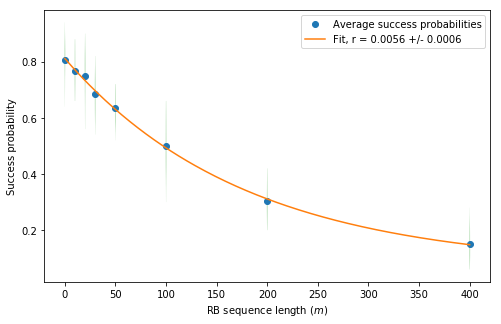

In [8]:
# This requires matplotlib, which is not a core dependency of pygsti
%matplotlib inline
rbresults.plot()

### Getting at the estimates
The various estimated paramaters (e.g., $r$) are stored in the `rbresults.fits` dictionary. Here, because we have implemented a standard practice analysis, there are two keys: `'full'` corresponding to the full fit, and `'A-fixed'` corresponding to the fit with the asymptote $A$ fixed to the value specified in the analysis.

In [9]:
rbresults.fits.keys()

dict_keys(['full', 'A-fixed'])

Each element of `rbresults.fits` is a `FitResults` object, which is just a container for the results of a fit (and a few simple methods. The most important information is the estimates of $A$, $B$, $p$ and $r$, accessed as follows:

In [10]:
rbresults.fits['full'].estimates

{'A': 0.06940091472213185,
 'B': 0.7416867585103045,
 'p': 0.9944080582863432,
 'r': 0.005586480833077102}

Note that even when a parameter was fixed to a constant, it will appear in the estimates list. To check which parameters were actually variables look at:

In [11]:
rbresults.fits['full'].variable

{'A': True, 'B': True, 'p': True}

We can look at the bootstrapped standard deviations:

In [12]:
rbresults.fits['full'].stds

{'A': 0.030554052986923097,
 'B': 0.02760426915998262,
 'p': 0.0006055105319884122,
 'r': 0.0006049192131095172}

And we can access the distribution of the bootstrapped values for any of these parameters, most importantly $r$. Below we histogram this distribution:

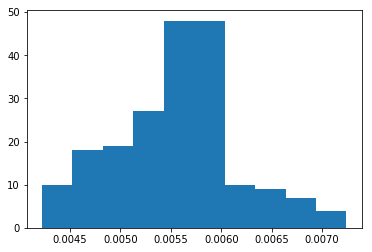

In [13]:
import matplotlib.pyplot as plt
plt.hist(rbresults.fits['full'].bootstraps['r'], 10)
plt.show()

Because we are doing this analysis on simulated data, we know what the DRB error rate should be according to the theory of DRB from ["Direct randomized benchmarking for multi-qubit devices"](https://arxiv.org/abs/1807.07975).

In [14]:
theory_predicted_r = 1 - (1-0.001)**5
observed_r = rbresults.fits['full'].estimates['r']
observed_r_std = rbresults.fits['full'].stds['r']
print("The theory-predicted r is: {}".format(theory_predicted_r))
print("The (simulated) observed r is: {} +/- {}".format(observed_r,observed_r_std))

The theory-predicted r is: 0.004990009995000988
The (simulated) observed r is: 0.005586480833077102 +/- 0.0006049192131095172
